In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, LSTM ,Dropout
from keras.callbacks import EarlyStopping
from keras import layers

from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


----------------------

#### 데이터 전처리

사용할 데이터 : 환율, 6개월 한국 미국 libor 금리, S&P 500, KOSPI200

#### 1. 환율

In [2]:
rate=pd.read_csv('data/set01.csv')
rate.columns=['date', 'rate']
rate=rate.set_index('date')
rate_train=rate.loc['2018-02-01': '2019-02-01' ]
rate_test=rate.loc['2019-02-01':'2019-03-01']

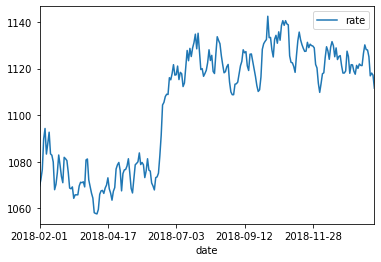

In [3]:
rate_train.plot()

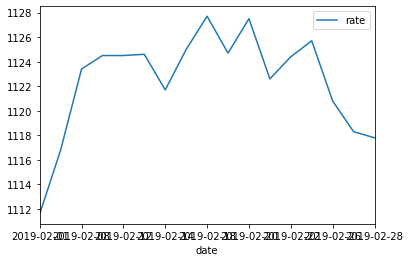

In [4]:
rate_test.plot()

#### 2. 한국 libor

In [5]:
kolib=pd.read_csv('data/KORIBOR.csv')
kolib=kolib[['date', '6month']]
kolib.columns=['date','krlibor']
kolib=kolib.set_index('date')
kolib_train=kolib.loc['2018-02-01': '2019-01-31' ]
kolib_test=kolib.loc['2019-02-01':'2019-03-01']

#### 3. 미국 libor

In [6]:
uslib=pd.read_csv('data/libor.csv')
uslib.columns=['date','uslibor']
uslib=uslib.set_index('date')
uslib_train=uslib.loc['2018-02-01': '2019-01-31' ]
uslib_test=uslib.loc['2019-02-01':'2019-02-31']

In [7]:
# 데이터에 일부분에 . 이 존재함. 
# 국가 공휴일은 삭제하고 필요한 값은 평균을 활용
del uslib_train['uslibor']['2018-12-25']
del uslib_train['uslibor']['2019-01-01']

In [8]:
uslib_train['uslibor'].loc['2018-03-30'] = (float(uslib_train['uslibor'].loc['2018-03-29']) * 2/3 
                                            + float(uslib_train['uslibor'].loc['2018-04-03']) * 1/3)

uslib_train['uslibor'].loc['2018-04-02'] = (float(uslib_train['uslibor'].loc['2018-03-29']) * 1/3 
                                            + float(uslib_train['uslibor'].loc['2018-04-03']) * 2/3)

uslib_train['uslibor'].loc['2018-05-07'] = (float(uslib_train['uslibor'].loc['2018-05-04']) * 1/2 
                                            + float(uslib_train['uslibor'].loc['2018-05-08']) * 1/2)

uslib_train['uslibor'].loc['2018-05-28'] = (float(uslib_train['uslibor'].loc['2018-05-25']) * 1/2 
                                            + float(uslib_train['uslibor'].loc['2018-05-29']) * 1/2)

uslib_train['uslibor'].loc['2018-08-27'] = (float(uslib_train['uslibor'].loc['2018-08-24']) * 1/2 
                                            + float(uslib_train['uslibor'].loc['2018-08-28']) * 1/2)

uslib_train['uslibor'].loc['2018-12-26'] = (float(uslib_train['uslibor'].loc['2018-12-24']) * 2/3 
                                            + float(uslib_train['uslibor'].loc['2018-12-27']) * 1/3)

/home/nvadmin/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/nvadmin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/nvadmin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/nvadmin/anacond

In [9]:
# 값이 문자형으로 되어있어서 실수형으로 변경
uslib_train['uslibor']=uslib_train['uslibor'].apply(pd.to_numeric)
uslib_test['uslibor']=uslib_test['uslibor'].apply(pd.to_numeric)

/home/nvadmin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/nvadmin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### 4.s&p 500

In [10]:
snp500=pd.read_csv('data/S&P500.csv')
snp500 = snp500[::-1]
snp500=snp500[['날짜','종가']]
snp500.columns=['date','snp500']


snp500_date=[]
for i in snp500['date']:
    snp500_date.append(i.replace('년 ','-').replace('월 ','-').replace('일',''))

snp500_price=[]
for i in snp500['snp500']:
    i=i.replace(',','')
    snp500_price.append(np.float(i))

snp500['date']=snp500_date
snp500['snp500']=snp500_price
snp500=snp500.set_index('date')

snp500_train = snp500.loc['2018-02-01': '2019-01-31' ]
snp500_test = snp500.loc['2018-02-01': '2019-02-31' ]

#### 5. kospi200

In [11]:
kospi200=pd.read_csv('data/KOSPI200.csv')
kospi200=kospi200[['날짜','종가']]
kospi200.columns=['date','kospi200']
kospi200 = kospi200[::-1]

kospi_date=[]
for i in kospi200['date']:
    kospi_date.append(i.replace('년 ','-').replace('월 ','-').replace('일',''))

kospi200['date']=kospi_date
kospi200=kospi200.set_index('date')


kospi200_train = kospi200.loc['2018-02-01': '2019-01-31' ]
kospi200_test=kospi200.loc['2019-02-01':'2019-03-01']

------------------

### 정리한 데이터를 활용하여 같은 날로 묶어서 하나의 dataframe 생성

In [12]:
data_train=pd.concat([rate_train,kolib_train,uslib_train,snp500_train,kospi200_train], axis=1,  join = 'inner', sort=False)
data_test=pd.concat([rate_test,kolib_test,uslib_test,snp500_test,kospi200_test], axis=1,  join = 'inner', sort=False)

In [13]:
print(data_train.shape)
print(data_test.shape)

(236, 5)
(16, 5)


In [14]:
data_train.head()

,rate,krlibor,uslibor,snp500,kospi200
date,,,,,
2018-02-01,1069.6,1.73,1.78698,2821.98,333.36
2018-02-02,1072.5,1.73,1.78902,2762.13,327.01
2018-02-05,1076.7,1.73,1.79345,2648.94,323.29
2018-02-06,1089.8,1.73,1.79070,2695.14,318.01
2018-02-07,1094.3,1.73,1.79989,2681.66,310.48


In [15]:
data_test.head()

,rate,krlibor,uslibor,snp500,kospi200
date,,,,,
2019-02-01,1111.6,1.90,2.73263,2706.53,285.79
2019-02-07,1116.8,1.90,2.69700,2706.05,285.65
2019-02-08,1123.4,1.91,2.69775,2707.88,281.49
2019-02-11,1124.5,1.90,2.68800,2709.80,282.10
2019-02-12,1124.5,1.90,2.69288,2744.73,283.69


#### 데이터 프레임 정리하기

In [16]:
data_train['y']=data_train['rate'].shift(-1)
data_test['y']=data_test['rate'].shift(-1)

In [17]:
#Nan 값을 계속 찾아서 업데이트 할 예정
data_train['y'][-1]=rate_test.iloc[0]
data_train=data_train[['krlibor','uslibor','snp500','kospi200','y']]

data_test['y'][-1]=rate_test.iloc[0]
data_test=data_test[['krlibor','uslibor','snp500','kospi200','y']]
data_test=data_test[:-1]

In [18]:
data_train.head()

,krlibor,uslibor,snp500,kospi200,y
date,,,,,
2018-02-01,1.73,1.78698,2821.98,333.36,1072.5
2018-02-02,1.73,1.78902,2762.13,327.01,1076.7
2018-02-05,1.73,1.79345,2648.94,323.29,1089.8
2018-02-06,1.73,1.79070,2695.14,318.01,1094.3
2018-02-07,1.73,1.79989,2681.66,310.48,1083.3


In [19]:
data_test.head()

,krlibor,uslibor,snp500,kospi200,y
date,,,,,
2019-02-01,1.90,2.73263,2706.53,285.79,1116.8
2019-02-07,1.90,2.69700,2706.05,285.65,1123.4
2019-02-08,1.91,2.69775,2707.88,281.49,1124.5
2019-02-11,1.90,2.68800,2709.80,282.10,1124.5
2019-02-12,1.90,2.69288,2744.73,283.69,1124.6


In [20]:
train_input = data_train[['krlibor','uslibor','snp500','kospi200']]
train_target = data_train['y']
test_input = data_test[['krlibor','uslibor','snp500','kospi200']]
test_target = data_test['y']

#### scale맞추기

In [21]:
mean = train_input.mean(axis=0)
std = train_input.std(axis=0)
train_input -= mean
train_input /= std
test_input -= mean
test_input /= std

In [22]:
train_input=np.array(train_input)
train_input=train_input.reshape(train_input.shape[0],4)

#### 모델 작성하기 (DNN)

In [ ]:
early_stopping = EarlyStopping(patience=50)

In [ ]:
model = Sequential()

model.add(layers.Dense(units=1024, input_shape=(4,)))
model.add(Dropout(0.1))

model.add(layers.Dense(units=128, input_shape=(4,)))
model.add(Dropout(0.1))

model.add(Dense(units=1))

model.compile(optimizer='tanh', loss='mean_squared_error')

In [ ]:
history = model.fit(train_input, train_target, epochs=1000, batch_size=32, validation_split=0.3, callbacks=[early_stopping])

#### loss값 그래프로 표현

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

In [ ]:
x_len = np.arange(len(y_loss))

plt.figure(figsize=(20,5))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### 예측하고 평가

In [ ]:
predicted = model.predict(test_input)
actual=data_test['y']

RMSE = mean_squared_error(actual, predicted)**0.5    
RMSE

#### 실제값 예측값 dataframe 만들기

In [ ]:
predicted = sum(predicted.tolist(), [])
actual=actual.tolist()

final=pd.DataFrame([predicted, actual]).T
final.columns=['pred','actual']
final=final.set_index(data_test.index)

#### 상승, 하락 표시

In [ ]:
#train set의 마지막 데이터
lastday=rate_train[-1:]['rate']

In [ ]:
actual_updown=[]
pred_updown=[]

if final['actual'][0] > lastday[0]:
    actual_updown.append('up')
else :
    actual_updown.appedn('down')
    
if final['pred'][0] > lastday[0]:
    pred_updown.append('up')
else :
    pred_updown.append('down')


for i in range(len(final)-1):
    
    if final['actual'][i+1] > final['actual'][i]:
        actual_updown.append('up')
    else :
        actual_updown.append('down')
        
for i in range(len(final)-1):
    
    if final['pred'][i+1] > final['actual'][i]:
        pred_updown.append('up')
    else :
        pred_updown.append('down')

In [ ]:
final['pred_updown']=pred_updown
final['actual_updown']=actual_updown

In [ ]:
final

In [ ]:
# 한달간 예측
print('한달간 상승,하락 정확도 : ',round(sum(final['pred_updown'] == final['actual_updown'])/len(final)*100,2), '%')

#5일만 예측
final_5=final[:5]
print('5일간 상승,하락 정확도 : ',round(sum(final_5['pred_updown'] == final_5['actual_updown'])/len(final_5)*100,2), '%')

#### 그림으로 표현

In [ ]:
plt.plot(predicted, label='pred')
plt.plot(actual, label='actual')
plt.legend(loc='best')
plt.show()